In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from catboost import CatBoostRegressor, Pool, cv
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from hyperopt import hp, fmin, STATUS_OK, STATUS_FAIL, tpe, Trials

pd.set_option('display.max_rows', 100)

In [2]:
df = pd.read_csv('./data/train_trees.csv')
test_df = pd.read_csv('./data/test_trees.csv')
df.head()

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,...,num_top_sch_2km,num_good_sch_1km,num_good_sch_2km,num_normal_sch_1km,num_normal_sch_2km,age,age_bin,shortest_dist_mall,shortest_ex_mrt,shortest_pl_mrt
0,2021-09-01,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1983-01-01,1.344518,...,1,0,2,2,4,38.693151,6,1.202674,0.699127,0.699127
1,2022-05-01,bedok,119,bedok north road,4 room,new generation,92.0,yes,1978-01-01,1.330186,...,2,1,1,3,6,44.358904,7,1.114338,0.898991,0.898991
2,2022-10-01,toa payoh,157,lorong 1 toa payoh,3 room,improved,67.0,yes,1971-01-01,1.332242,...,4,0,1,1,3,51.783562,9,0.468297,0.218603,0.218603
3,2021-08-01,pasir ris,250,Pasir Ris Street 21,executive,apartment,149.0,yes,1993-01-01,1.370239,...,0,2,2,1,4,28.600000,4,0.402359,1.546040,1.546040
4,2022-11-01,kallang/whampoa,34,Whampoa West,3 room,improved,68.0,yes,1972-01-01,1.320502,...,1,0,1,1,2,50.868493,8,1.073354,0.187856,0.187856


In [3]:
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)
train_df.shape, val_df.shape

((53754, 32), (5973, 32))

In [4]:
all_cols = ['town', 'flat_type', 'flat_model', 'subzone', 'planning_area', 'region',
            'num_top_sch_1km', 'num_top_sch_2km', 'num_good_sch_1km', 'num_good_sch_2km', 'num_normal_sch_1km', 'num_normal_sch_2km',
            'age_bin', 'age', 'floor_area_sqm', 'shortest_dist_school', 'shortest_dist_mall', 'shortest_ex_mrt', 'shortest_pl_mrt', 'sti', 'coe']
y_col = ['monthly_rent']
train_df = train_df[all_cols + y_col]
test_df = test_df[all_cols]
print(len(all_cols))
train_df.head()

21


,town,flat_type,flat_model,subzone,planning_area,region,num_top_sch_1km,num_top_sch_2km,num_good_sch_1km,num_good_sch_2km,...,age_bin,age,floor_area_sqm,shortest_dist_school,shortest_dist_mall,shortest_ex_mrt,shortest_pl_mrt,sti,coe,monthly_rent
46682,queenstown,5 room,standard,dover,queenstown,central region,1,1,0,1,...,7,45.443836,117.0,0.490373,0.263181,0.486722,0.486722,0.536411,0.966841,4700
25386,hougang,executive,apartment,trafalgar,hougang,north-east region,1,3,2,3,...,3,22.016438,137.0,0.181800,0.153121,1.626200,1.626200,0.000000,0.042686,2200
27347,jurong west,4 room,model a,hong kah,jurong west,west region,1,1,1,3,...,6,37.273973,107.0,0.491038,0.522755,0.881589,0.881589,0.561993,0.126418,2100
25636,bishan,5 room,improved,bishan east,bishan,central region,0,1,1,3,...,6,36.024658,121.0,0.625651,0.518611,0.550143,0.550143,0.677828,0.778767,3000
23101,bukit merah,4 room,model a,kampong tiong bahru,bukit merah,central region,0,0,1,3,...,4,26.430137,108.0,0.426200,0.831461,0.822746,0.822746,0.536411,0.966841,4300


In [34]:
# x_col = ['town', 'flat_type', 'flat_model', 'subzone', 'planning_area', 'region',
#          'num_top_sch_1km', 'num_top_sch_2km', 'num_good_sch_1km', 'num_good_sch_2km', 'num_normal_sch_1km', 'num_normal_sch_2km',
#          'age_bin', 'age', 'floor_area_sqm', 'shortest_dist_school', 'shortest_dist_mall', 'shortest_ex_mrt', 'shortest_pl_mrt', 'sti', 'coe']
# n_cat_cols = 13

x_col = ['flat_type', 'region', 'num_top_sch_2km', 'num_top_sch_1km', 'num_good_sch_1km', 'num_good_sch_2km',
         'age', 'floor_area_sqm', 'shortest_dist_school', 'shortest_dist_mall', 'shortest_ex_mrt', 'shortest_pl_mrt', 'sti', 'coe']
n_cat_cols = 6

train_pool = Pool(train_df[x_col], train_df[y_col], cat_features=np.arange(n_cat_cols))
val_pool = Pool(val_df[x_col], val_df[y_col], cat_features=np.arange(n_cat_cols))
test_pool = Pool(test_df[x_col], cat_features=np.arange(n_cat_cols))

cat_model = CatBoostRegressor(iterations=50,
                          depth=4,
                          learning_rate=0.8,
                          bootstrap_type='Bernoulli',
                          subsample=0.8,
                          loss_function='RMSE',
                          task_type='GPU')
# train the model
cat_model.fit(train_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 566.1425032	total: 4.13ms	remaining: 202ms
1:	learn: 538.8881599	total: 8.14ms	remaining: 195ms
2:	learn: 517.6090608	total: 11.9ms	remaining: 187ms
3:	learn: 513.6334030	total: 15.4ms	remaining: 178ms
4:	learn: 510.3931514	total: 18.9ms	remaining: 170ms
5:	learn: 506.5754985	total: 22.3ms	remaining: 164ms
6:	learn: 504.1157097	total: 26.3ms	remaining: 162ms
7:	learn: 502.3974698	total: 29.7ms	remaining: 156ms
8:	learn: 501.3793343	total: 33.1ms	remaining: 151ms
9:	learn: 500.4459432	total: 36.5ms	remaining: 146ms
10:	learn: 499.1544067	total: 40.3ms	remaining: 143ms
11:	learn: 498.7168170	total: 44.1ms	remaining: 140ms
12:	learn: 498.0528267	total: 47.5ms	remaining: 135ms
13:	learn: 497.3193700	total: 50.9ms	remaining: 131ms
14:	learn: 496.6914252	total: 54.6ms	remaining: 127ms
15:	learn: 495.9299892	total: 59ms	remaining: 125ms
16:	learn: 495.2388761	total: 62.5ms	remaining: 121ms
17:	learn: 494.2617470	total: 65.8ms	remaining: 117ms
18:	learn: 493.0553419	total: 69.3ms	rem

In [35]:
# evaluate on validation set
preds = cat_model.predict(val_pool)
np.sqrt(mean_squared_error(val_df[y_col], preds))

488.9702275327901

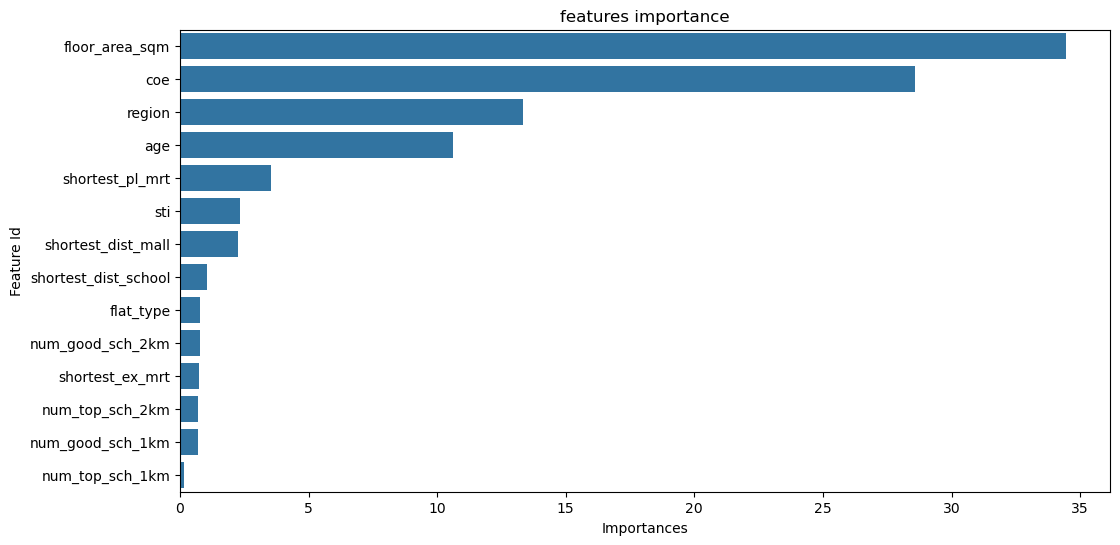

In [36]:
# Create a dataframe of feature importance
df_feature_importance = pd.DataFrame(cat_model.get_feature_importance(prettified=True))
#plotting feature importance
plt.figure(figsize=(12, 6));
feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance);
plt.title('features importance');

In [37]:
preds = cat_model.predict(test_pool)
preds

array([3126.75664528, 2789.62737244, 3376.18089037, ..., 2908.58152038,
       3353.40079539, 3311.76692873])

In [38]:
submission_df = pd.DataFrame({'Predicted': preds})
submission_df.rename_axis('Id', inplace=True)
submission_df.to_csv('./data/submission_trees.csv')

In [9]:
class HPOptimiser(object):
    def __init__(self, train_pool, val_pool):
        self.train_pool = train_pool
        self.val_pool = val_pool

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials

    def catboost_reg(self, para):
        reg = CatBoostRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def train_reg(self, reg, params):
        reg.fit(self.train_pool,
                eval_set=self.val_pool,
                **params['fit_params'])
        pred = reg.predict(self.val_pool)
        loss = params['loss_func'](val_pool.get_label(), pred)
        return {'loss': loss, 'status': STATUS_OK}

In [10]:
# Catboost hyperparameters to search
catboost_hyperparams = { 'learning_rate': hp.choice('learning_rate', [0.1, 0.5, 0.75, 1.0]),
                         'max_depth': hp.choice('max_depth', np.arange(3, 9, 1, dtype=int)),
                         'colsample_bylevel': hp.choice('colsample_bylevel', [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
                         'subsample': hp.choice('subsample', np.arange(0.6, 1.0, 0.2, dtype=float)),
                        #  'n_estimators': hp.choice('colsample_bylevel', np.arange(50, 200, 50, dtype=int)),
                         'iterations': hp.choice('iterations', np.arange(50, 200, 50, dtype=int)),
                         'l2_leaf_reg': hp.choice('l2_leaf_reg', [None, 1, 5, 10, 20]),
                         'loss_function': 'RMSE',
                         'eval_metric': 'RMSE'}

catbooast_fit_params = { 'early_stopping_rounds': 10, 'verbose': False }

catboost_params = dict()
catboost_params['reg_params'] = catboost_hyperparams
catboost_params['fit_params'] = catbooast_fit_params
catboost_params['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

In [11]:
optimiser = HPOptimiser(train_pool, val_pool)

catboost_opt = optimiser.process(fn_name='catboost_reg', space=catboost_params,
                          trials=Trials(), algo=tpe.suggest, max_evals=100)

100%|██████████| 100/100 [22:33<00:00, 13.54s/trial, best loss: 487.6658495845369]


In [12]:
catboost_opt

({'colsample_bylevel': 1,
  'iterations': 4,
  'l2_leaf_reg': 1,
  'learning_rate': 1,
  'max_depth': 3},
 <hyperopt.base.Trials at 0x23d5f23aad0>)